# Part 4 - Location

#### 01 - Load Data

In [27]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [17]:
data_country = pd.read_csv("./data/map_dataset.csv")
data_country = data_country['country'].value_counts()
data_country = data_country.rename_axis('country').reset_index(name='count')
data_country

,country,count
0,United States of America,7602
1,India,2044
2,United Kingdom,1934
3,Canada,1210
4,Germany,969
...,...,...
196,Vietna,1
197,Czech Republi,1
198,Swede,1
199,Egyp,1


#### 02 - Visualize the tweet data on the world map
- Here, choose to use geopandas library

In [26]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/lf/d4sqcry51bd2c08x3w3x_9040000gn/T/ipykernel_60841/1414067789.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [43]:
df_world['name'] = df_world['name'].astype('str')
data_country['country'] = data_country['country'].astype('str')
df_world_teams = df_world.merge(data_country, how="left", left_on=['name'], right_on=['country'])

/var/folders/lf/d4sqcry51bd2c08x3w3x_9040000gn/T/ipykernel_60841/1679960580.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


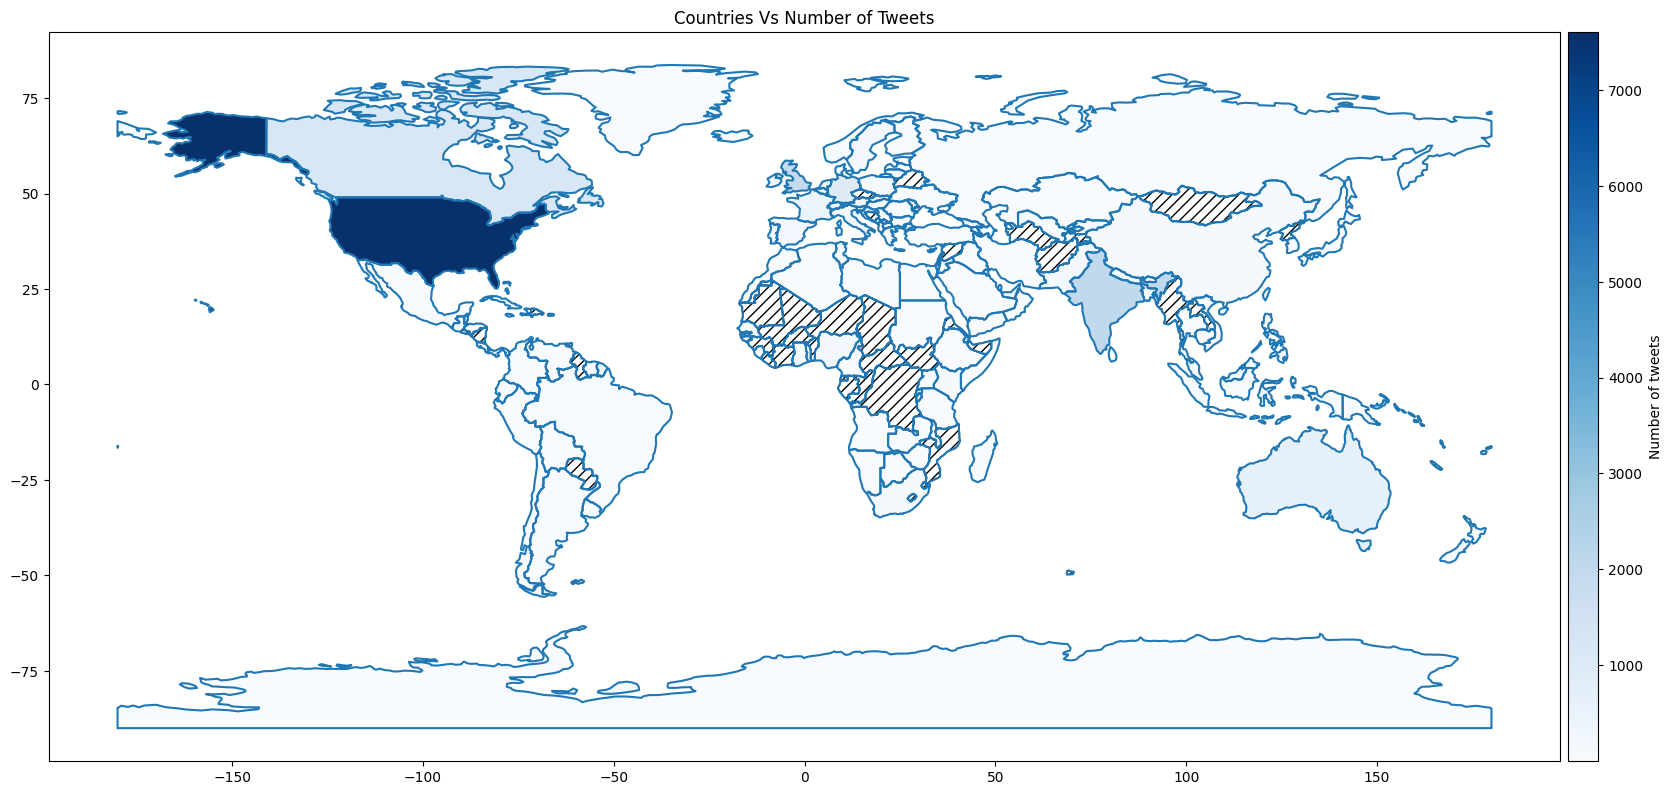

In [47]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df_world['name'] = df_world['name'].astype('str')
data_country['country'] = data_country['country'].astype('str')

df_world_teams = df_world.merge(data_country, how="left", left_on=['name'], right_on=['country'])

def addColorbar():
    fig, ax = plt.subplots(1, 1, figsize=(20, 16))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad="0.5%")
    return ax, cax

ax, cax = addColorbar()
df_world["geometry"].boundary.plot(ax=ax, figsize=(20,16))
df_world_teams.plot(column='count', ax=ax, cax=cax, cmap='Blues', legend=True,
                    legend_kwds={"label": "Number of tweets"},
                    missing_kwds={"color": "white", "edgecolor": "black", "hatch": "///"})

ax.set_title("Countries Vs Number of Tweets")

plt.show()

#### 03 - Location and Sentiment

In [31]:
data_ori = pd.read_csv('./data/tweets_with_sentiment_label.csv')
data_ori_location = data_ori['user_location'].unique()
np.savetxt('./data/location_original.txt',data_ori_location,fmt='%s',encoding='UTF-8')

/var/folders/lf/d4sqcry51bd2c08x3w3x_9040000gn/T/ipykernel_60841/4043104583.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_ori = pd.read_csv('./data/tweets_with_sentiment_label.csv')


In [32]:
for i in range(40):
    np.savetxt('./data/original_locations/locations_pad_{}'.format(i),data_ori_location[i*200:i*200+200],fmt='%s',encoding='UTF-8')

In [33]:
# Here, convert the original locations by <**convert_locations.py**>
# after locations convert, then create a dict to change the location

dict_test = {}
for i in range(39):
       with open('./data/original_locations_json/locations_json_pad_{}.txt'.format(i),'r',encoding='UTF-8') as f:
                for line in f.readlines():
                    try:
                        str_key = line[:].split(': ')[0][1:-1]
                        str_value = line[:-2].split(': ')[1][1:-1]
                        if str_value == 'US' or str_value == 'USA' or str_value=='United States':
                            str_value = 'United States of America'
                        dict_test[str_key] = str_value

                    except:
                        print(i)
                        print(line)

In [34]:
def get_country(x):
    try:
        name = dict_test[x]
        if name == 'a' or name == '':
            return 'NaN'
        else:
            return dict_test[x]
    except:
        return 'NaN'

data_ori['country']=data_ori['user_location'].apply(lambda x:get_country(x))

selected_data = data_ori[['label_roberta', 'country']]
cleaned_data = selected_data[selected_data['country'] != 'NaN']

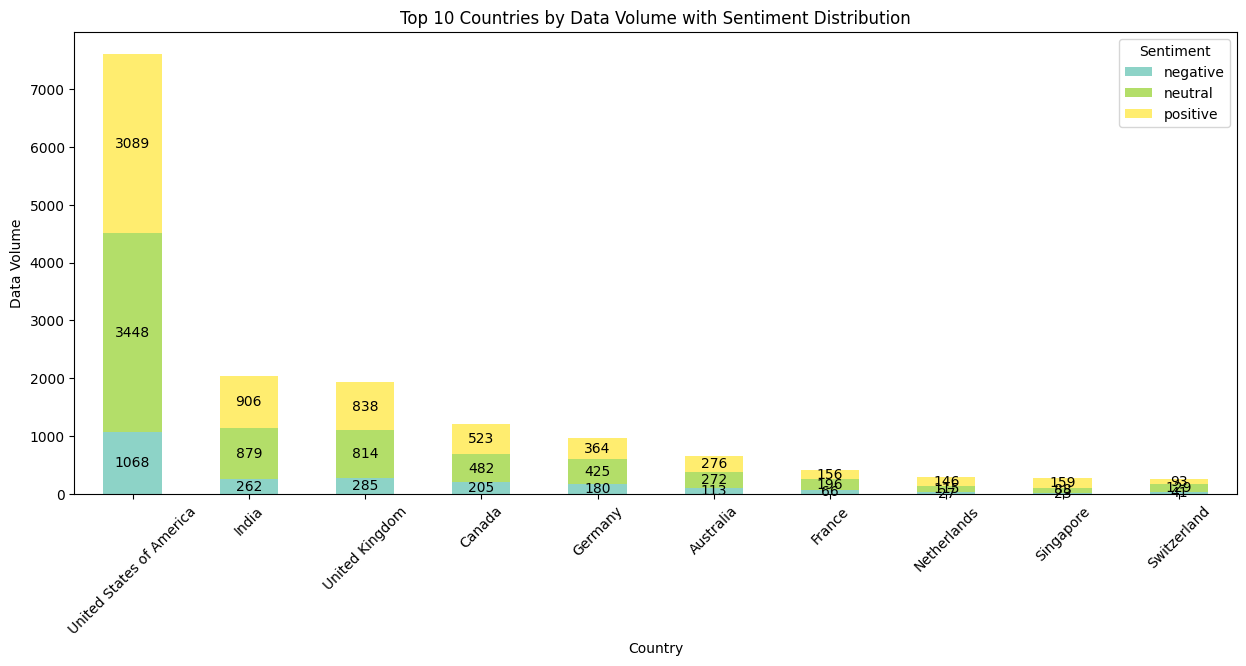

<Figure size 1500x1000 with 0 Axes>

In [37]:
country_counts = cleaned_data.groupby(['country', 'label_roberta']).size().unstack(fill_value=0)
country_counts.rename(columns={-1: 'negative', 0: 'neutral', 1: 'positive'}, inplace=True)

top_countries = country_counts.sum(axis=1).nlargest(10).index
top_countries_data = country_counts.loc[top_countries]

ax = plt.gca()
top_countries_data.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', figsize=(15, 6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.text(x+width/2, y+height/2, '{:.0f}'.format(height), 
                horizontalalignment='center', verticalalignment='center')

plt.title("Top 10 Countries by Data Volume with Sentiment Distribution")
plt.xlabel("Country")
plt.ylabel("Data Volume")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.figure(figsize=(15, 10))

plt.tight_layout()
plt.show()

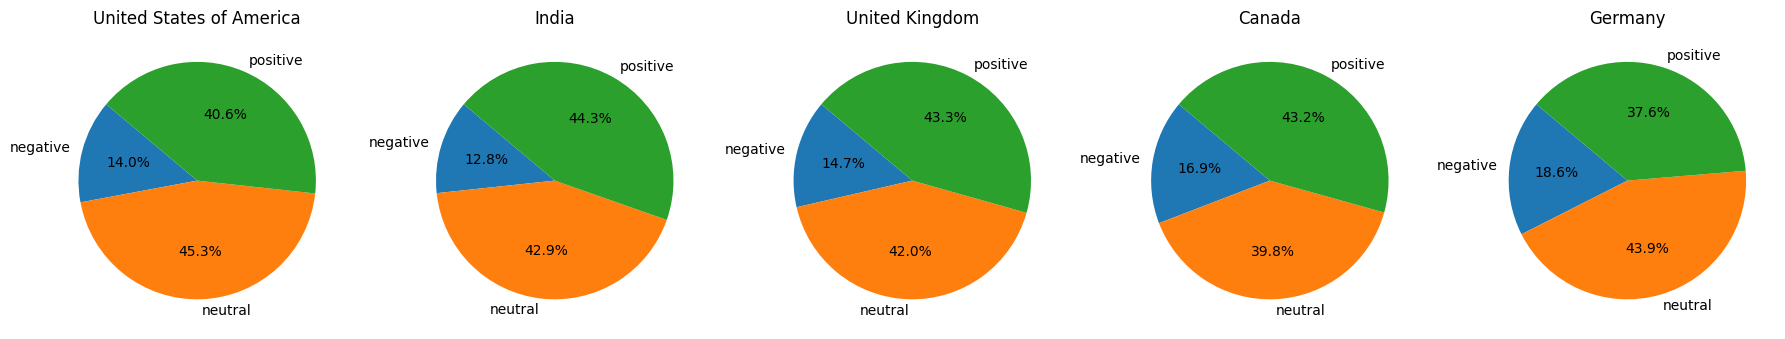

In [42]:
country_counts.rename(columns={-1: 'negative', 0: 'neutral', 1: 'positive'}, inplace=True)
top_5_countries = country_counts.sum(axis=1).nlargest(5).index

fig, axes = plt.subplots(1, 5, figsize=(18, 5))
for i, country in enumerate(top_5_countries):
    sizes = country_counts.loc[country].values
    labels = country_counts.columns
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(country)

plt.tight_layout()
plt.show()
